# Pipeline for vehicle detection in video
--CLASSIFIER TRAINING
1. Choose features to extract from train images
2. Transform each training image into feature vector
3. Use these labeled feature vectors to train classifier

--TRACKING PIPELINE
1. Slice image into boxes using sliding window
2. Run each window frame through classifier to get car prediction
3. Save position of positive detections
4. Use heatmap to merge duplicates and remove false positives

In [1]:
# import statements
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm 

### Misc. Functions

#### Draw boxes function

In [2]:
# draw boxes after corners are detected
# boxes argument is an array of tuples, one for each box to draw, 2 corners in each box
# boxes = [((corner1), (corner2)), ((corner1), (corner2)), ((corner1), (corner2))]
# corners = (x,y)
def draw_boxes(img, boxes, color=(0,0,255), thick=6):
    # make copy of image
    draw_image = np.copy(img)
    # draw each box in boxes list
    for box in boxes:
        cv2.rectangle(draw_image, box[0], box[1], color, thick)
    
    return draw_image

DRAW BOXES VISUALIZATION

In [3]:
# # load images
# test_images = glob.glob('test_images/*')
# image_num = 3
# img = mpimg.imread(test_images[image_num])
# plt.imshow(img)

# boxes = [((800,400),(950, 510)), ((1020,400),(1275,510))]
# plt.imshow(draw_boxes(img, boxes))

# Feature Extraction

VISUALIZATION

+ Explore color spaces to use as features

In [4]:
# # load images
# colorspace_cutouts = glob.glob('colorspace_cutouts/*')
# test_images = colorspace_cutouts[6:]
# cars = colorspace_cutouts[:3]
# background = colorspace_cutouts[3:]
# cutout = cv2.imread(background[0])
# test_img = cv2.imread(test_images[2])


# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

# def plot3d(pixels, colors_rgb,
#         axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
#     """Plot pixels in 3D."""

#     # Create figure and 3D axes
#     fig = plt.figure(figsize=(8, 8))
#     ax = Axes3D(fig)

#     # Set axis limits
#     ax.set_xlim(*axis_limits[0])
#     ax.set_ylim(*axis_limits[1])
#     ax.set_zlim(*axis_limits[2])

#     # Set axis labels and sizes
#     ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
#     ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
#     ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
#     ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

#     # Plot pixel values with colors given in colors_rgb
#     ax.scatter(
#         pixels[:, :, 0].ravel(),
#         pixels[:, :, 1].ravel(),
#         pixels[:, :, 2].ravel(),
#         c=colors_rgb.reshape((-1, 3)), edgecolors='none')

#     return ax  # return Axes3D object for further manipulation


# # Read a color image
# img = cutout

# # Select a small fraction of pixels to plot by subsampling it
# scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
# img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# # Convert subsampled image to desired color space(s)
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
# img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
# img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
# img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
# img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# # show original image
# plt.imshow(img)

# # Plot and show
# plot3d(img_small_RGB, img_small_rgb)
# plt.show()

# plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
# plt.show()

# plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
# plt.show()

# plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
# plt.show()

#### Color conversion

In [5]:
# assumes cv2 or BGR conversion

def convert_color(img, convert='RGB'):
    if convert == 'RGB':
        convert_image =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif convert == 'HSV':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif convert == 'LUV':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif convert == 'HLS':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif convert == 'YUV':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif convert == 'YCrCb':
        convert_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        
    return convert_image

#### Histogram of color channels

In [6]:
# find histograms of each color channel
def color_hist(img, nbins=32, bins_range=(0,256)):
    # find histograms of each color channel
    channel1 = np.histogram(img[:,:,0], nbins, bins_range)
    channel2 = np.histogram(img[:,:,1], nbins, bins_range)
    channel3 = np.histogram(img[:,:,2], nbins, bins_range)
    
    # concatenate into single feature vector
    hist_features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    
    ## VISUALIZATION ##
    # calculate bin centers based on nbins and bins_range parameters
#     bin_edges = channel1[1]
#     bin_centers = (bin_edges[1:] + bin_edges[:len(bin_edges)-1]) / 2
#     return channel1, channel2, channel3, bin_centers, feature_vector

    return hist_features

HISTOGRAM VISUALIZATION

In [7]:
# # load images
# template_images = glob.glob('template_images/*')
# img = mpimg.imread(template_images[0])
# templates = template_images[1:]
# temp_img = mpimg.imread(templates[0])


# channel1, channel2, channel3, bin_centers, feature_vector = color_hist(temp_img)


# ## plot individual histograms ##
# fig = plt.figure(figsize=(12,3))
# plt.subplot(131)
# plt.bar(bin_centers, rhist[0])
# plt.xlim(0, 256)
# plt.title('R Histogram')
# plt.subplot(132)
# plt.bar(bin_centers, ghist[0])
# plt.xlim(0, 256)
# plt.title('G Histogram')
# plt.subplot(133)
# plt.bar(bin_centers, bhist[0])
# plt.xlim(0, 256)
# plt.title('B Histogram')
# fig.tight_layout()

#### Spatial binned features

In [8]:
# after selecting colorspace which best separates car pixels, use it to define a feature vector
def bin_spatial(img, size=(32,32)):
    bin_spatial_features = cv2.resize(img, size).ravel()
    return bin_spatial_features

SPATIAL BIN VISUALIZATION

In [9]:
# ## remove .ravel() in function

# template_images = glob.glob('template_images/*')
# img = mpimg.imread(template_images[0])

# plt.imshow(img)
# plt.imshow(bin_spatial(img))

#### HOG gradient features

In [10]:
# add gradient vector to add structural information to the classifier
# accepts single color channel or grayscale
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # return list of [hog_features, hog_image]
    return_values = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                       cells_per_block=(cell_per_block,cell_per_block), visualize=True, feature_vector=feature_vec, \
                       block_norm="L2-Hys")
    
    hog_features = return_values[0]
    hog_image = return_values[1]
    if vis:
        return hog_features, hog_image
    else:
        return hog_features

HOG VISUALIZATION

In [11]:
# # load images
# template_images = glob.glob('template_images/*')
# img = mpimg.imread(template_images[3])

# # parameters for hog function
# orient = 9
# pix_cell = 8
# cell_block = 2

# # convert to gray
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# # get hog_features and hog_image
# hog_feat, hog_img = get_hog_features(gray, orient, pix_cell, cell_block)

# # show images
# plt.figure()
# plt.imshow(img)

# plt.figure()
# plt.imshow(hog_img, cmap='gray')

#### EXTRACTION FUNCTION

MULTIPLE IMAGES (training data)

In [12]:
# Use this function to extract all feature vectors from list of images
# inputs list of image paths

def extract_features(img_list, orient, pix_per_cell, cell_per_block, color_space='RGB',\
                     nbins=32, spatial_size=(32,32), feature_vec=True, hog_channel='GRAY',\
                     hist_feat=True, spatial_feat=True, hog_feat=True):

    # create features list, append vector for each image
    features_list = []
    for image in img_list:
        # list to save selected features for each image
        img_features = []
        # read in image using cv2 = BGR
        img = cv2.imread(image)
        # convert to selected colorspace
        feature_image = convert_color(img, color_space)
        
        # create color histogram features
        if hist_feat:
            hist_vector = color_hist(feature_image, nbins)
            img_features.append(hist_vector)
        # create spatial binned features
        if spatial_feat:
            spatial_vector = bin_spatial(feature_image, spatial_size)
            img_features.append(spatial_vector)
        # create hog features
        if hog_feat:
            # selected which channels of image to run hog features on (ALL, GRAY, 0, 1, or 2)
            if hog_channel == 'GRAY':
                gray = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
                hog_vector = get_hog_features(gray, orient, pix_per_cell, cell_per_block, feature_vec=feature_vec)
            elif hog_channel == 'ALL':
                hog_vector = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block,\
                                                        feature_vec=feature_vec))
            else:
                hog_vector = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,\
                                             feature_vec=feature_vec)
            img_features.append(hog_vector)
            
        # add feature vector for each image
        features_list.append(np.concatenate(img_features))
    return features_list

SINGLE IMAGES (sliding windows)

In [13]:
# Use this function to extract all feature vectors from single image
# to be called for each defined by slide_windows()
# inputs single image plus parameters

def single_image_features(image, orient, pix_per_cell, cell_per_block, color_space='RGB',\
                     nbins=32, spatial_size=(32,32), feature_vec=True, hog_channel='GRAY',\
                          hist_feat=True, spatial_feat=True, hog_feat=True):
    
    # create features list, append vector for each image
    feature_list = []
    # convert to selected colorspace
    feature_image = convert_color(image, color_space)
    
    # create color histogram features
    if hist_feat:
        hist_vector = color_hist(feature_image, nbins)
        feature_list.append(hist_vector)
    # create spatial binned features
    if spatial_feat:
        spatial_bin_vector = bin_spatial(feature_image, spatial_size)
        feature_list.append(spatial_bin_vector)
    # create hog features
    if hog_feat:
        # selected which channels of image to run hog features on (ALL, GRAY, 0, 1, or 2)
        if hog_channel == 'GRAY':
            gray = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_vector = get_hog_features(gray, orient, pix_per_cell, cell_per_block, feature_vec=feature_vec)
        elif hog_channel == 'ALL':
            hog_vector = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block,\
                                                    feature_vec=feature_vec))
        else:
            hog_vector = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,\
                                         feature_vec=feature_vec)
        feature_list.append(hog_vector)
    
    return np.concatenate(feature_list)

# CLASSIFICATION

#### PARAMETERS

In [34]:
# parameters for feature extraction function
orient = 15
pix_per_cell = 8
cell_per_block = 2
cspace = 'HSV'
nbins = 32
spatial_size = (32,32)
hog_channel = 'GRAY'
hist_feat = True
spatial_feat = True
hog_feat = True

# slide_windows() parameters
x_bounds = [[None,None],[None,None], [None,None]]
y_bounds = [[500,600],[500,575],[500,700]] 
window = [(50,50),(110,75),(100,100)] #(width,height)
overlap = [(0.6,0),(0.6,0),(0.6,0)]

#### PREPARE TRAINING DATA

In [15]:
# load training images
cars_train = glob.glob('vehicle_training_set/vehicles_smallset/*.jpeg')
non_cars_train = glob.glob('vehicle_training_set/non-vehicles_smallset/*.jpeg')

# extract feature vectors from training images
cars_features = extract_features(cars_train, orient, pix_per_cell, cell_per_block, color_space=cspace,\
                                 nbins=nbins, spatial_size=spatial_size, hog_channel='GRAY',\
                                hist_feat=True, spatial_feat=True, hog_feat=True)
non_cars_features = extract_features(non_cars_train, orient, pix_per_cell, cell_per_block, color_space=cspace,\
                                 nbins=nbins, spatial_size=spatial_size, hog_channel='GRAY',\
                                hist_feat=True, spatial_feat=True, hog_feat=True)

# create labels for each training set 1 == car, 0 == non-car
cars_labels = np.ones(len(cars_features))
non_cars_labels = np.zeros(len(non_cars_features))

# combine training data and labels
X = np.vstack((cars_features, non_cars_features)).astype(np.float64)
y = np.hstack((cars_labels, non_cars_labels))

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## scale data
# FIT SCALER ON TRAINING SET ONLY
X_scaler = StandardScaler().fit(X_train)
# apply scaler to data
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

#### Explore dataset

In [16]:
def explore_dataset(car_images, noncar_images):
    data_dict = {}
    data_dict['num_cars'] = len(car_images)
    data_dict['num_noncars'] = len(noncar_images)
    example_image = cv2.imread(car_images[0])
    data_dict['image_shape'] = example_image.shape
    data_dict['data_type'] = example_image.dtype
    return data_dict

In [17]:
data_dict = explore_dataset(cars_train, non_cars_train)
for key in data_dict:
    print('{}:\t'.format(key), data_dict[key])

data_type:	 uint8
num_cars:	 1196
num_noncars:	 1125
image_shape:	 (64, 64, 3)


#### BUILD CLASSIFIER

In [18]:
# use grid search to optimize porameters
parameters = {'kernel':('linear', 'rbf'), 'C':[1,10]}
sv = svm.SVC()
# clf = GridSearchCV(sv, parameters)
clf = sv

# train classifier
clf.fit(scaled_X_train, y_train)

# check accuracy on test set
print('Accuracy of SVM on test set: ', clf.score(scaled_X_test, y_test))

# ground truth test
print('Predictions: ', clf.predict(scaled_X_test[:15]))
print('Ground truth: ', y_test[:15])

Accuracy of SVM on test set:  0.991397849462
Predictions:  [ 1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.]
Ground truth:  [ 1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.]


In [20]:
# print(clf.best_params_)

# SLIDING WINDOWS

In [35]:
# creates a list of window boxes for searching
# all input parameters must be 2D lists to support multiple scales
# ONLY NEEDS OT BE RUN ON ONE IMAGE
def slide_windows(img, x_start_stop=[[None, None]], y_start_stop=[[None, None]], 
                    xy_window=[(64, 64)], xy_overlap=[(0.5, 0.5)]):
    
    # checks if input parameters are of equal length
    list_length = len(x_start_stop)
    if (len(y_start_stop) != list_length) or (len(xy_window) != list_length) or (len(xy_overlap) != list_length):
        raise Exception('All arguments must be of equal length!!')
    
    # Initialize a list to append window positions to
    window_list = []
    # loop through each bounding area and xy_window size to create windows on multiple scales
    for i in range(len(x_start_stop)):
        # If x and/or y start/stop positions not defined, set to image size
        if not x_start_stop[i][0]:
            x_start_stop[i][0] = 0
        if not x_start_stop[i][1]:
            x_start_stop[i][1] = img.shape[1]

        if not y_start_stop[i][0]:
            y_start_stop[i][0] = 0
        if not y_start_stop[i][1]:
            y_start_stop[i][1] = img.shape[0]

        # Compute the span of the region to be searched
        xspan = x_start_stop[i][1] - x_start_stop[i][0]
        yspan = y_start_stop[i][1] - y_start_stop[i][0]

        # Compute the number of pixels per step in x/y
        xstep = np.int(xy_window[i][0] * (1 - xy_overlap[i][0]))
        ystep = np.int(xy_window[i][1] * (1 - xy_overlap[i][1]))

        # Compute the number of windows in x/y
        windows_x = np.int(1 + (xspan - xy_window[i][0]) / xstep)
        windows_y = np.int(1 + (yspan - xy_window[i][1]) / ystep)

        # Loop through finding x and y window positions
        for ny in range(windows_y):
            for nx in range(windows_x):
                # Calculate each window position
                x_shift = xstep * nx
                y_shift = ystep * ny
                top_left = (x_start_stop[i][0] + x_shift, y_start_stop[i][0] + y_shift)
                bottom_right = (top_left[0] + xy_window[i][0], top_left[1] + xy_window[i][1])
                # Append window position to list
                window_list.append((top_left, bottom_right))
    # Return the list of windows
    return window_list

SLIDE WINDOW VISUALIZATION

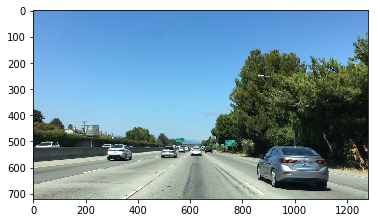

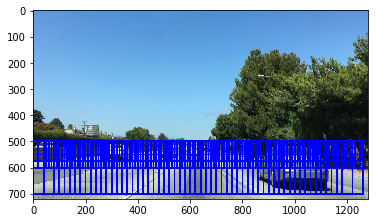

In [36]:
# load images
template_images = glob.glob('template_images/*')
img = cv2.imread(template_images[0])
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# define windows
windows = slide_windows(img, x_start_stop=x_bounds, y_start_stop=y_bounds, xy_window=window, xy_overlap=overlap)
boxed_image = draw_boxes(rgb, windows)

# show images
plt.figure()
plt.imshow(rgb)

plt.figure()
plt.imshow(boxed_image)

# SEARCH WINDOWS

In [37]:
# extracts features from each window section on an image and uses the classifier to make a prediction
def search_windows(image, windows, clf, scaler, orient, pix_per_cell, cell_per_block, color_space='RGB',\
                  nbins=32, size=(32,32), hog_channel='GRAY', hist_feat=True, spatial_feat=True, hog_feat=True):
    
    car_windows = []
    # iterate through all windows (x,y)
    for window in windows:
        y_start = window[0][1]
        y_end = window[1][1]
        x_start = window[0][0]
        x_end = window[1][0]
        
        # slice out window of original image and reshape to size of training images
        sub_image = cv2.resize(image[y_start:y_end, x_start:x_end], (64,64))
#         sub_image = image[y_start:y_end, x_start:x_end]
    
        # extract feature vector from each sub_image
        window_features = single_image_features(sub_image, orient, pix_per_cell, cell_per_block, color_space=color_space,\
                                                nbins=nbins, spatial_size=size, hog_channel=hog_channel, hist_feat=hist_feat,\
                                                spatial_feat=spatial_feat, hog_feat=hog_feat)
        
        # scale features 
        test_features = scaler.transform(np.array(window_features).reshape(1,-1))
        
        # make prediction for each window
        pred = clf.predict(test_features)
        
        # if car was predicted, append to car_windows
        if pred == 1:
            car_windows.append(window)
        
    return car_windows

FOUND CARS VISUALIZATION

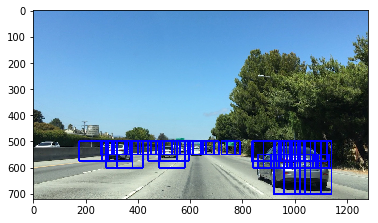

In [38]:
car_boxes = search_windows(img, windows, clf, X_scaler, orient, pix_per_cell, cell_per_block, cspace, nbins, spatial_size)
detected_image = draw_boxes(rgb, car_boxes)
plt.imshow(detected_image)

# HEAT MAPS

In [39]:
# use heat map to merge duplicate boxes
def add_heat(heatmap, box_list):
    # loop through list of bounding boxes found to be cars
    for box in box_list:
        # add 1 for every pixel in box
        # box = ((x1,y1),(x2,y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] +=1
    return heatmap

In [40]:
# threshold to eliminate false positives
def heat_thresh(heatmap, thresh):
    heatmap[heatmap <= thresh] = 0
    return heatmap

HEAT MAP VISUALIZATION

5 cars found


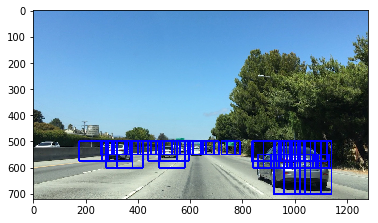

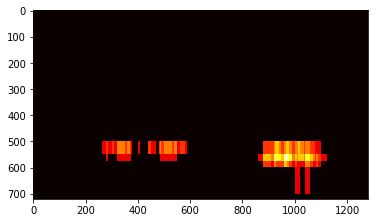

In [43]:
box_list = car_boxes # use car boxes from previous cell
image = detected_image # use detected image from previous cell
heatmap = np.zeros_like(image[:,:,0]).astype(np.float) # define heatmap

# create heatmap
heat = add_heat(heatmap, box_list)
heat = heat_thresh(heat, 2)
# create labels from heatmap
labels = label(heatmap)
print(labels[1], 'cars found')

plt.figure()
plt.imshow(image)

plt.figure()
plt.imshow(heat, cmap='hot')